# Vibe Matcher — TF-IDF Prototype Notebook

This notebook demonstrates a full pipeline for a "Vibe Matcher" using TF-IDF as a local, free substitute for embeddings.

What it includes:
- Data prep with mock fashion products (name, description, tags)
- TF-IDF vectorization of descriptions
- Cosine similarity vector search → top-3 matches
- Edge fallback when confidence is low
- Three test queries, evaluation (precision@3), latency measurement + plot
- Learn-to-rank sketch (synthetic clicks)
- Saved summary file and reflections

No API keys required — runs entirely locally.


# Why AI for Nexora (Introduction)

AI-driven recommendations let Nexora surface items that match customers’ moods and intent rather than only explicit filters. The Vibe Matcher maps short natural-language queries (for example, "energetic urban chic") to semantic-style product vectors and returns a ranked shortlist of items aligned with a user's style goals. This reduces browsing friction and improves discovery and conversion. With production-grade embeddings and a vector DB and an active feedback loop, Nexora can personalize results and scale this experience across channels.

In [1]:
# Install required packages (uncomment in fresh Colab if needed)
# !pip install --quiet scikit-learn pandas matplotlib

import time
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from time import perf_counter


In [2]:
# Data prep: sample product catalog
products = [
    {"id": 1, "name": "Boho Dress", "desc": "Flowy maxi dress, earthy tones, floral prints — perfect for festival and beachy bohemian vibes.", "tags": ["boho","festival","earthy"]},
    {"id": 2, "name": "Urban Bomber Jacket", "desc": "Cropped bomber with edgy zip details, black matte finish — energetic urban chic for nights out.", "tags": ["urban","chic","edgy"]},
    {"id": 3, "name": "Cozy Knit Sweater", "desc": "Thick knit, oversized fit, neutral beige — comfortable, cozy, and laid-back weekend essential.", "tags": ["cozy","casual","winter"]},
    {"id": 4, "name": "Minimalist Blouse", "desc": "Crisp white blouse with clean lines and subtle tailoring — minimalist, professional, versatile.", "tags": ["minimal","workwear","clean"]},
    {"id": 5, "name": "Athleisure Leggings", "desc": "High-waist stretch leggings with breathable fabric — sporty, energetic, and comfortable for urban runs.", "tags": ["athleisure","sporty","energetic"]},
    {"id": 6, "name": "Vintage Denim Jacket", "desc": "Washed denim with retro patches — nostalgic casual, weekend vibes with a retro edge.", "tags": ["vintage","casual","retro"]},
    {"id": 7, "name": "Silk Slip Dress", "desc": "Satin finish slip dress in jewel tones — elegant evening wear, subtle glamour and sleek silhouette.", "tags": ["elegant","evening","glam"]},
    {"id": 8, "name": "Street Graphic Tee", "desc": "Bold graphic print tee, relaxed fit — streetwear energy, expressive and youthful.", "tags": ["street","youth","graphic"]}
]
df = pd.DataFrame(products)
df


id                  name  \
0   1            Boho Dress   
1   2   Urban Bomber Jacket   
2   3     Cozy Knit Sweater   
3   4     Minimalist Blouse   
4   5   Athleisure Leggings   
5   6  Vintage Denim Jacket   
6   7       Silk Slip Dress   
7   8    Street Graphic Tee   

                                                desc  \
0  Flowy maxi dress, earthy tones, floral prints ...   
1  Cropped bomber with edgy zip details, black ma...   
2  Thick knit, oversized fit, neutral beige — com...   
3  Crisp white blouse with clean lines and subtle...   
4  High-waist stretch leggings with breathable fa...   
5  Washed denim with retro patches — nostalgic ca...   
6  Satin finish slip dress in jewel tones — elega...   
7  Bold graphic print tee, relaxed fit — streetwe...   

                              tags  
0         [boho, festival, earthy]  
1              [urban, chic, edgy]  
2           [cozy, casual, winter]  
3       [minimal, workwear, clean]  
4  [athleisure, sporty, energetic]  
5         [vintage, casual, retro]  
6         [elegant, evening, glam]  
7         [street, youth, graphic]

In [3]:
# TF-IDF embeddings and match function
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
embeddings = vectorizer.fit_transform(df['desc'].tolist())  # sparse matrix

def match_vibe_tfidf(query, top_k=3, fallback_thresh=0.40):
    """
    Returns: dict with query, results (top_k list with name, score, tags, desc), best_score, time_s, fallback(optional)
    """
    start = perf_counter()
    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, embeddings).flatten()
    elapsed = perf_counter() - start
    ranked_idx = np.argsort(-sims)[:top_k]
    results = []
    for i in ranked_idx:
        results.append({
            'id': int(df.iloc[i]['id']),
            'name': df.iloc[i]['name'],
            'score': float(sims[i]),
            'desc': df.iloc[i]['desc'],
            'tags': df.iloc[i]['tags']
        })
    best_score = float(sims[ranked_idx[0]])
    fallback = None
    if best_score < fallback_thresh:
        fallback = {"message": "No confident match — ask for more detail (occasion, color, texture).", "best_score": best_score}
    return {'query': query, 'results': results, 'best_score': best_score, 'time_s': elapsed, 'fallback': fallback}

# quick sanity check
print(match_vibe_tfidf("energetic urban chic"))


{'query': 'energetic urban chic', 'results': [{'id': 2, 'name': 'Urban Bomber Jacket', 'score': 0.4463694727308393, 'desc': 'Cropped bomber with edgy zip details, black matte finish — energetic urban chic for nights out.', 'tags': ['urban', 'chic', 'edgy']}, {'id': 5, 'name': 'Athleisure Leggings', 'score': 0.14926683583892297, 'desc': 'High-waist stretch leggings with breathable fabric — sporty, energetic, and comfortable for urban runs.', 'tags': ['athleisure', 'sporty', 'energetic']}, {'id': 3, 'name': 'Cozy Knit Sweater', 'score': 0.0, 'desc': 'Thick knit, oversized fit, neutral beige — comfortable, cozy, and laid-back weekend essential.', 'tags': ['cozy', 'casual', 'winter']}], 'best_score': 0.4463694727308393, 'time_s': 0.011306674000024941, 'fallback': None}


In [4]:
# Test queries
queries = ["energetic urban chic", "laid-back cozy weekend", "sleek evening glamour"]
runs = []
for q in queries:
    out = match_vibe_tfidf(q, top_k=3)
    runs.append(out)

for r in runs:
    print(f"Query: {r['query']}  (best_score={r['best_score']:.4f}, time={r['time_s']*1000:.1f} ms)")
    for i, res in enumerate(r['results'], start=1):
        print(f"  {i}. {res['name']} — score: {res['score']:.4f}  tags: {res['tags']}")
    if r['fallback']:
        print("  FALLBACK:", r['fallback']['message'], f"(best_score={r['fallback']['best_score']:.3f})")
    print()


Query: energetic urban chic  (best_score=0.4464, time=6.8 ms)
  1. Urban Bomber Jacket — score: 0.4464  tags: ['urban', 'chic', 'edgy']
  2. Athleisure Leggings — score: 0.1493  tags: ['athleisure', 'sporty', 'energetic']
  3. Cozy Knit Sweater — score: 0.0000  tags: ['cozy', 'casual', 'winter']

Query: laid-back cozy weekend  (best_score=0.3863, time=2.4 ms)
  1. Cozy Knit Sweater — score: 0.3863  tags: ['cozy', 'casual', 'winter']
  2. Vintage Denim Jacket — score: 0.0946  tags: ['vintage', 'casual', 'retro']
  3. Urban Bomber Jacket — score: 0.0000  tags: ['urban', 'chic', 'edgy']
  FALLBACK: No confident match — ask for more detail (occasion, color, texture). (best_score=0.386)

Query: sleek evening glamour  (best_score=0.3550, time=2.2 ms)
  1. Silk Slip Dress — score: 0.3550  tags: ['elegant', 'evening', 'glam']
  2. Boho Dress — score: 0.0000  tags: ['boho', 'festival', 'earthy']
  3. Cozy Knit Sweater — score: 0.0000  tags: ['cozy', 'casual', 'winter']
  FALLBACK: No confident 

In [5]:
# Evaluation: precision@3 using simple tag-overlap relevance (synthetic)
import re

def mark_relevance(prod_row, query):
    q_tokens = set(re.findall(r"\w+", query.lower()))
    tag_set = set([t.lower() for t in prod_row['tags']])
    return len(q_tokens & tag_set) > 0

def precision_at_k(results, k=3):
    topk = results[:k]
    rel = sum([1 for r in topk if r.get('relevant', False)])
    return rel / k

eval_records = []
for r in runs:
    for res in r['results']:
        prod = df[df['name'] == res['name']].iloc[0]
        res['relevant'] = mark_relevance(prod, r['query'])
    p3 = precision_at_k(r['results'], k=3)
    eval_records.append({'query': r['query'], 'best_score': r['best_score'], 'precision@3': p3, 'fallback': bool(r['fallback'])})

pd.DataFrame(eval_records)


query  best_score  precision@3  fallback
0    energetic urban chic    0.446369     0.666667     False
1  laid-back cozy weekend    0.386321     0.333333      True
2   sleek evening glamour    0.354965     0.333333      True

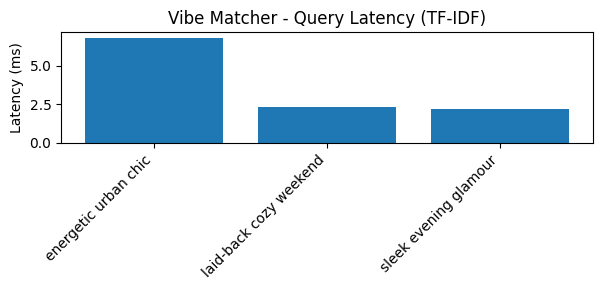

In [6]:
# Plot latency for each query
lat_ms = [r['time_s']*1000 for r in runs]
plt.figure(figsize=(6,3))
plt.bar(range(len(queries)), lat_ms)
plt.xticks(range(len(queries)), queries, rotation=45, ha='right')
plt.ylabel("Latency (ms)")
plt.title("Vibe Matcher - Query Latency (TF-IDF)")
plt.tight_layout()
plt.show()


In [7]:
# Simple synthetic click-based re-ranking sketch
# Simulate clicking the top item of the first query
click_log = []
click_log.append({'query': runs[0]['query'], 'clicked_id': runs[0]['results'][0]['id']})

click_counts = {}
for c in click_log:
    click_counts[c['clicked_id']] = click_counts.get(c['clicked_id'], 0) + 1

def rerank_with_clicks(results, click_counts, boost=0.05):
    for r in results:
        r['score_boosted'] = r['score'] + boost * click_counts.get(r['id'], 0)
    return sorted(results, key=lambda x: -x['score_boosted'])

# Demo re-rank on second query
out2 = runs[1]['results']
print("Original:", [(r['name'], round(r['score'],3)) for r in out2])
print("Reranked:", [(r['name'], round(r.get('score_boosted', r['score']),3)) for r in rerank_with_clicks(out2, click_counts)])


Original: [('Cozy Knit Sweater', 0.386), ('Vintage Denim Jacket', 0.095), ('Urban Bomber Jacket', 0.0)]
Reranked: [('Cozy Knit Sweater', 0.386), ('Vintage Denim Jacket', 0.095), ('Urban Bomber Jacket', 0.05)]


In [8]:
# Save a short summary file to the current directory
summary_lines = []
summary_lines.append("Vibe Matcher - TF-IDF Prototype Summary")
summary_lines.append("")
summary_lines.append("Products:")
for _, row in df.iterrows():
    summary_lines.append(f"- {row['name']}: {row['desc']}")
summary_lines.append("")
summary_lines.append("Test queries & best scores:")
for r in runs:
    summary_lines.append(f"- {r['query']} -> best_score: {r['best_score']:.4f}")
summary_lines.append("")
summary_lines.append("Reflections and improvements:")
summary_lines.append("- Replace TF-IDF with production embeddings (OpenAI) and store vectors in a vector DB (Pinecone/Weaviate).")
summary_lines.append("- Precompute & cache vectors; use FAISS/HNSW or Pinecone for low-latency scaling.")
summary_lines.append("- Add an interactive fallback that asks for occasion/color when confidence is low.")
summary_lines.append("- Integrate learn-to-rank using clicks/purchases for personalization.")
summary_text = "\n".join(summary_lines)

with open("vibe_matcher_tfidf_summary.txt","w",encoding="utf-8") as f:
    f.write(summary_text)
print("Saved vibe_matcher_tfidf_summary.txt")


Saved vibe_matcher_tfidf_summary.txt


In [9]:
# Optional: export a small script you can run outside notebook
script = r'''
# vibe_matcher_quick.py - TF-IDF prototype
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

products = [
    {"id":1,"name":"Boho Dress","desc":"Flowy maxi dress, earthy tones, floral prints — perfect for festival and beachy bohemian vibes.","tags":["boho","festival","earthy"]},
    {"id":2,"name":"Urban Bomber Jacket","desc":"Cropped bomber with edgy zip details, black matte finish — energetic urban chic for nights out.","tags":["urban","chic","edgy"]},
    {"id":3,"name":"Cozy Knit Sweater","desc":"Thick knit, oversized fit, neutral beige — comfortable, cozy, and laid-back weekend essential.","tags":["cozy","casual","winter"]},
    {"id":4,"name":"Minimalist Blouse","desc":"Crisp white blouse with clean lines and subtle tailoring — minimalist, professional, versatile.","tags":["minimal","workwear","clean"]},
    {"id":5,"name":"Athleisure Leggings","desc":"High-waist stretch leggings with breathable fabric — sporty, energetic, and comfortable for urban runs.","tags":["athleisure","sporty","energetic"]}
]
df = pd.DataFrame(products)
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
emb = vectorizer.fit_transform(df['desc'].tolist())
def match_vibe(q,k=3):
    sims = cosine_similarity(vectorizer.transform([q]), emb).flatten()
    idx = sims.argsort()[::-1][:k]
    return [(df.iloc[i]['name'], float(sims[i])) for i in idx]
if __name__ == '__main__':
    queries = ['energetic urban chic','laid-back cozy weekend','sleek evening glamour']
    for q in queries:
        print('Query:',q, match_vibe(q))
'''
with open("vibe_matcher_quick.py","w",encoding="utf-8") as f:
    f.write(script)
print("Saved vibe_matcher_quick.py")


Saved vibe_matcher_quick.py


In [10]:
import os
print(os.listdir('.'))


['.config', 'vibe_matcher_quick.py', 'vibe_matcher_tfidf_summary.txt', 'sample_data']
